In [510]:

#Import modules
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, brier_score_loss


## Data generation, import and missing values

We first generate features and target variables for prediction by running the data generation script.
We use aggregations of transactions for the latest 3000 days (full history excluding the latest 60 days), and the latest 60 days prior to the loan date. These time horizons can be passed to the script as arguments and adjusted as you like.

In [436]:
!ipython credit_risk_datagen.py 3000 60

#open the pickled dataset generated by the script
with open('loan_data', 'rb') as file:
    loans = pickle.load(file, encoding="latin1")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\shellapp.py:340: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  raise_exceptions=True)
credit_risk_datagen.py:181: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trans_agg = trans_agg[(data.date_loan - data.date).dt.days > time_window_min]


In [437]:
#Missing observations
print('Missing observations')
print(loans.isna().sum()[loans.isna().sum() > 0])
print('\nTotal cases with missing data: ', loans.isna().sum(axis=1).sum())
print(round(100*loans.isna().sum(axis=1).sum()/len(loans), 2),'% of total cases.')
print('Loans behind in payment with missing data: ', (loans[loans.isna().sum(axis=1).astype(bool)].target == 1).sum())
print('Total number of loans behind in payment: ', loans.target.sum())
print('Account age of loan with missing rate_max: ', loans[loans.rate_max.isna()].accnt_age.values[0])
print('Minimum age of loans: ', min(loans.accnt_age))
loans['rate_max'] = loans.rate_max.fillna(loans.rate_max_short)

Missing observations
applicants    8
rate_min      1
rate_mean     1
rate_max      1
dtype: int64

Total cases with missing data:  11
1.64 % of total cases.
Loans behind in payment with missing data:  3
Total number of loans behind in payment:  75.0
Account age of loan with missing rate_max:  0.2792607802874743
Minimum age of loans:  0.2792607802874743


The missing applicant data is from the earliest part of the data, which we can assume can be safely ignored. Additionally one observation for historical maximum rate is missing. The account associated has not been granted interest payments 60 days prior to loan issuance. We will replace the NA with the 2 month value.

We generate the final feature matrix X and target vector y.

In [438]:
X = loans[~loans.isna().sum(axis=1).astype(bool)]
y = X.target
X.drop(['target'], axis=1, inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Baseline models

We will begin with a baseline logistic regression models with the kitchen sink approach, using all generated features for prediction. 

With a large set of features and a low number of observations, logistic regression tends to get spurious. To combat this, I use an L1 (Lasso) penalty. L1 penalty has the advantage over the default L2 penalty (ridge) in that it shrinks small coefficients to 0, which should be useful for feature selection later.

In addition I standardize the features. Standardizing helps the regression algorithm to converge and makes for easier interpretation of the coefficients as all are at the same scale.

Because there are relatively few loans that default, accuracy is not an ideal metric of model performance. Furthermore, because predictions are of interest in evaluating credit risk and setting loan rates, the predicted probability has a meaningful interpretation. I complement the prediction accuracy with the brier score which measures the mean squared difference between the predicted probability assigned to the problems in loan repayment and the actual outcome. The lower the brier score loss is, the better.

Because there is a time-series element to the data, ideally we would want to use a time-series split for cross-validation to make sure ex-post information does not affect model performance. However, because we have little data and the time-seriesness of the data is not likely to be a major concern, we will settle with 10-fold cross-validation.

We also generate the accuracy for the naive prediction that all loans complete succesfully. For the brier score loss we generate the benchmark loss for the naive prediction that the probability of a default is the same (sample mean) across all observations.

In [439]:
def create_pipeline(classifier):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('clf', classifier)])
    return pipe

kfold = StratifiedKFold(n_splits=10)
scorer = make_scorer(brier_score_loss, needs_proba=True)
benchmark_acc = 1-np.mean(y)
benchmark_brier = brier_score_loss(y, np.repeat(np.mean(y), len(y)))

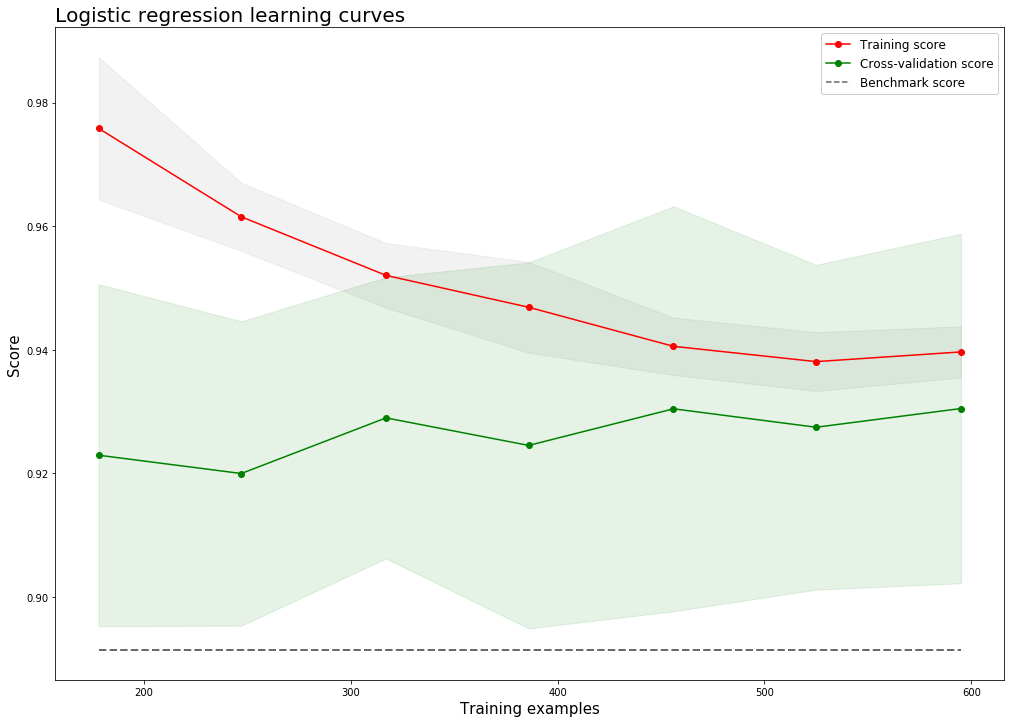

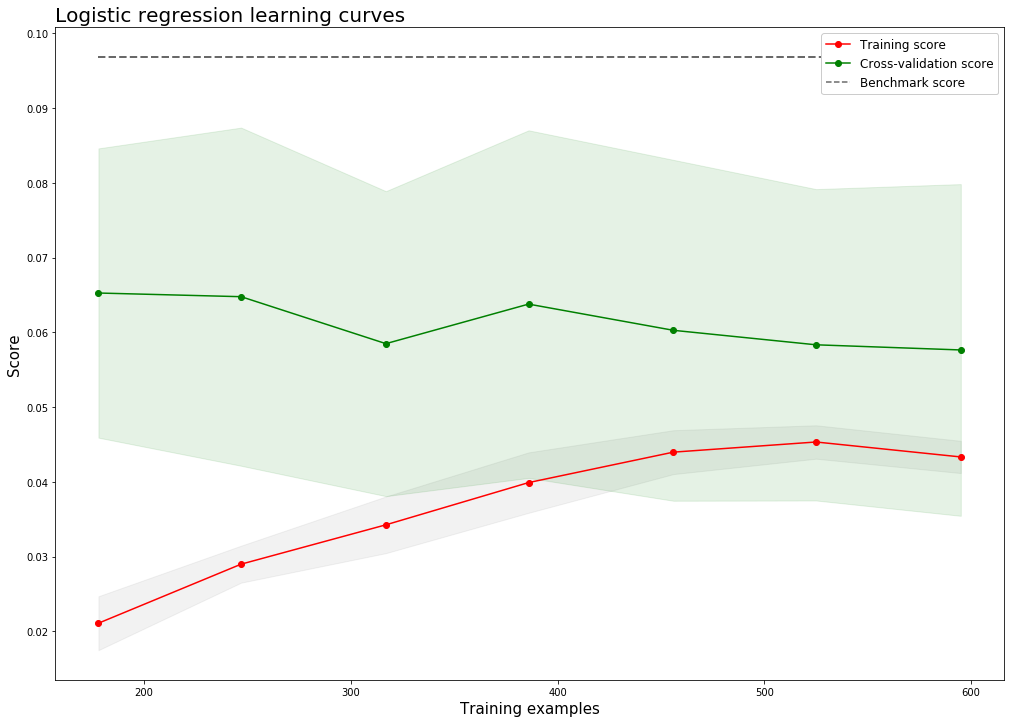

In [440]:
logc = create_pipeline(LogisticRegression(penalty='l1', solver='liblinear'))

g = plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_acc)
g = plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_brier,
                       scoring = scorer)

## Feature selection for logistic regression

I simplify the linear baseline model, by using recursive sklearn's pre-built recursive feature selection by cross-validation. Recursive feature elimination removes the least important features recursively by fitting and refitting the linear classification model with less and less features. 

I first run a quick gridsearch cross-validation to sort out suitable parameters for the penalty used, strength of the regularization penalty and whether to use weighted classes.

In [528]:
search_params = {'clf__C':np.linspace(0.1, 2, 20),
                 'clf__penalty':['l1', 'l2'],
                  'clf__class_weight':[None, 'balanced']
                }
search = GridSearchCV(logc, search_params, cv=kfold)
search.fit(X, y)
params = dict(zip(['C','class_weight','penalty'],search.best_params_.values()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


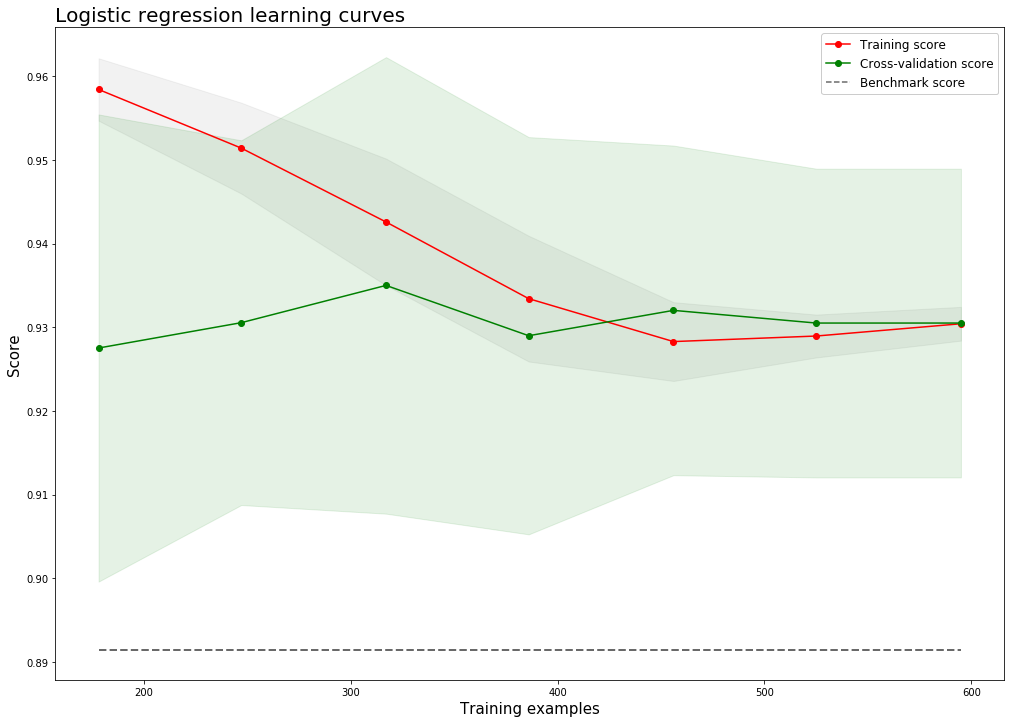

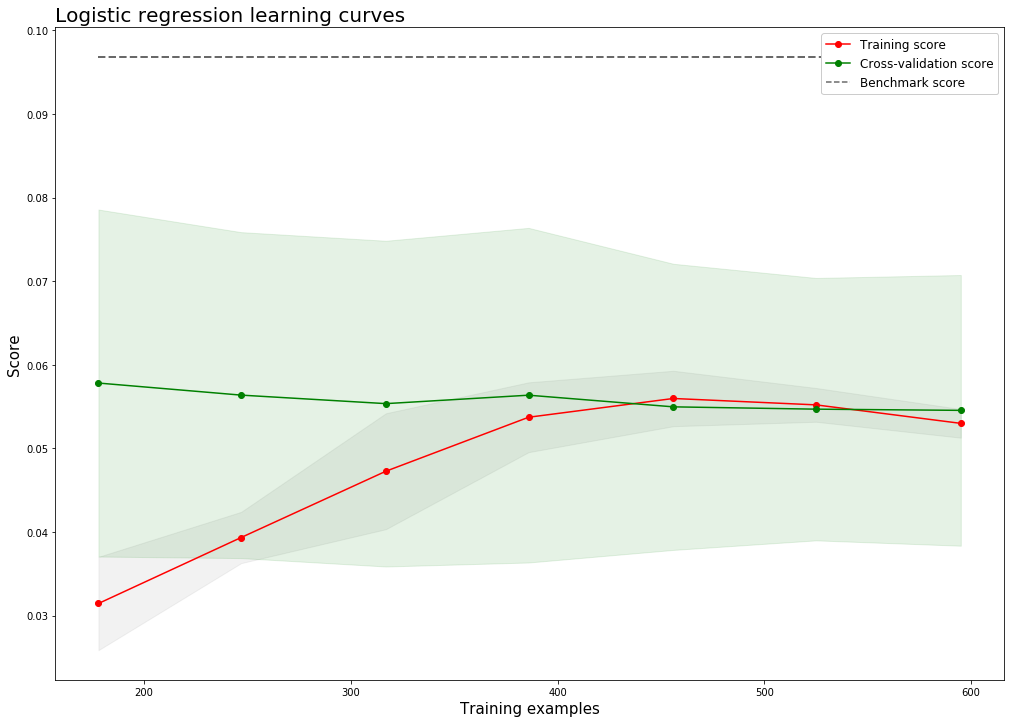

In [529]:
def create_rfe_pipeline(classifier):
    pipe =  [
        ('std_scaler', StandardScaler()),
        ('clf', classifier)
    ]
    class PipelineRFE(Pipeline):

        def fit(self, X, y=None, **fit_params):
            super(PipelineRFE, self).fit(X, y, **fit_params)
            self.coef_ = self.steps[-1][-1].coef_
            return self
    return(PipelineRFE(pipe))

logc_features = create_rfe_pipeline(LogisticRegression(**params, solver='liblinear'))

rfecv = RFECV(estimator=logc_features, step=1, cv=kfold,
              scoring='neg_log_loss')
rfecv.fit(X, y)


g, bm_lin_acc = plot_learning_curve(logc,"Logistic regression learning curves",X.loc[:,rfecv.support_], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_acc)
g, bm_lin_brier = plot_learning_curve(logc,"Logistic regression learning curves",X.loc[:,rfecv.support_], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_brier,
                       scoring = scorer)

In [531]:
print('Model coefficients')
for n, g in (list(zip(list(rfecv.estimator_.coef_[0]), list(X.columns[rfecv.support_])))):
   print(round(n, 3), '\t', g)

Model coefficients
0.347 	 payments
-0.447 	 multi
0.745 	 neg_bal
-0.383 	 balance_min_short
0.629 	 sanc_max_short
0.657 	 rate_mean_short


We end up with a 6-feature logistic regression model that seems to perform slightly better than the kitchen sink regression model. This model provides a good benchmark for more sophisticated models.
Payments has a positive coefficient,
Neg_bal is a dummy variable indicating, whether the account has had a negative balance over the existence of the. It has the largest positie coefficient, i.e. an account having had a negative balance strongly indicates that it is much more likely that the loan will not be repaid fully. The balance 

## Gradient Boosting Model

We first run a similar feature selection than for the logistic regression.

In [ ]:
params = {'n_estimators': 300, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}
rfecv_gb = RFECV(estimator=AdaBoostClassifier(**params), step=1, cv=kfold,
              scoring='neg_log_loss')
rfecv_gb.fit(X, y)

In [ ]:
mask = rfecv_gb.support_
adc = AdaBoostClassifier(**{'n_estimators': 300, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'})

g, _ = plot_learning_curve(adc,"Gradient boosting learning curves",X.loc[:,mask], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = bm_lin_acc)
g, _ = plot_learning_curve(adc,"Gradient boosting learning curves",X.loc[:,mask], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = bm_lin_brier,
                       scoring = scorer)

In [504]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from matplotlib.lines import Line2D


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), benchmark=None,
                       scoring=None):
    """
    Adapted from here:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    _, axes = plt.subplots(1, 1, figsize=(17, 12))
    axes.set_title(title, loc='left', size=20)
    if ylim is not None:
        axes.set_ylim(*ylim)

    axes.set_xlabel("Training examples", size=15)
    axes.set_ylabel("Score", size=15)

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if benchmark is not None:
        plt.plot(train_sizes[:], np.zeros(len(train_sizes))+benchmark, ls="--",
                 color = "dimgrey", lw=2)
    # Plot learning curve
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="grey")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="green")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    lg = axes.legend(loc="upper right", framealpha=1, fontsize='large')
    
    ax = lg.axes
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Line2D([0], [0], color='dimgrey', ls='--'))
    labels.append("Benchmark score")
    
    lg._legend_box = None
    lg._init_legend_box(handles, labels)
    lg._set_loc(lg._loc)
    lg.set_title(lg.get_title().get_text())
    return plt, test_scores_mean